In [1]:
!pip install mpi4py

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621


In [2]:
%%writefile bifurcation.py

import matplotlib.pyplot as plt
from mpi4py import MPI
import numpy as np

def parallel_bifurcation(proc, points_X = 1000, n_proc = 8, minX = 0, maxX = 4, steps = 1000, m = 30):
    block_X = points_X // n_proc # integer blocks of x axis
    remainder = points_X % n_proc # remainder for the last block

    add = 0 # addition of the last block
    if proc == n_proc - 1: # if current process is last
        add = remainder # addition is equal to remainder
    
    # current x array
    arrayX = np.arange(block_X * proc, block_X * (proc + 1) + add, 1)
    
    r = np.linspace((proc) * maxX / n_proc, (proc + 1) * maxX / n_proc, arrayX.size)
    # print(arrayX.size)
    
    X = np.zeros((block_X, m)) # array for scatterplot
    Y = np.zeros((block_X, m)) # array for scatterplot
    x = np.zeros(steps)
    
    for j in range(0, block_X, 1):
        x[0] = np.random.rand()
        
        for n in range(1,steps):
            x[n] = r[j] * x[n-1] * (1 - x[n-1])
            
        X[j] = (x[steps-m:steps]) # take into account the last m values
        Y[j] = r[j] # set r value for each x[inf] - for scatter plot
    return X, Y

comm = MPI.COMM_WORLD
n_proc = comm.Get_size() # processors
rank = comm.Get_rank() # current rank

if rank == 0:
    print('number of processes = ', n_proc)
    t0 = MPI.Wtime() # measure start time

X, Y = parallel_bifurcation(proc = rank, points_X = 2000, n_proc = n_proc, minX = 0, maxX = 4, steps = 500, m = 40)
X, Y = comm.gather(X, root=0), comm.gather(Y, root=0)

if rank == 0:
    t = MPI.Wtime() - t0
    with open('./time.csv', 'a+') as f:
         f.write(f'{n_proc}, {np.round(t, 4) * 1000}\n')
    print('computation time = ', np.round(t, 4) * 1000, 'ms')

    fig = plt.scatter(Y, X, c = 'b', s = 0.1)

    #plt.figure(figsize=(15, 9))
    #plt.xlim((0, 4))   # set the xlim to left, right
    #plt.ylim(0, 1)     # set the xlim to left, right
    plt.title('Bifurcation diagram', fontsize=14)
    plt.ylabel('Values of static points', fontsize=14)
    plt.xlabel('Value of r', fontsize=14)
    plt.savefig(f'./bifurcation_{n_proc}_processes', dpi = 200)
    plt.close()

Overwriting bifurcation.py


In [3]:
%%bash
for k in {1..10}
do
    for i in {1..8}
    do
      mpirun --oversubscribe -n $i python3 bifurcation.py   
    done
done

number of processes =  1
computation time =  1066.3 ms
number of processes =  2
computation time =  513.9 ms
number of processes =  3
computation time =  341.3 ms
number of processes =  4
computation time =  275.8 ms
number of processes =  5
computation time =  282.8 ms
number of processes =  6
computation time =  262.6 ms
number of processes =  7
computation time =  267.79999999999995 ms
number of processes =  8
computation time =  261.6 ms
number of processes =  1
computation time =  990.6 ms
number of processes =  2
computation time =  505.49999999999994 ms
number of processes =  3
computation time =  340.2 ms
number of processes =  4
computation time =  265.0 ms
number of processes =  5
computation time =  272.1 ms
number of processes =  6
computation time =  287.7 ms
number of processes =  7
computation time =  266.90000000000003 ms
number of processes =  8
computation time =  267.0 ms
number of processes =  1
computation time =  989.5 ms
number of processes =  2
computation time 

In [4]:
import pandas as pd
time = pd.read_csv("./time.csv", header=None, names=["n_proc", "time"])

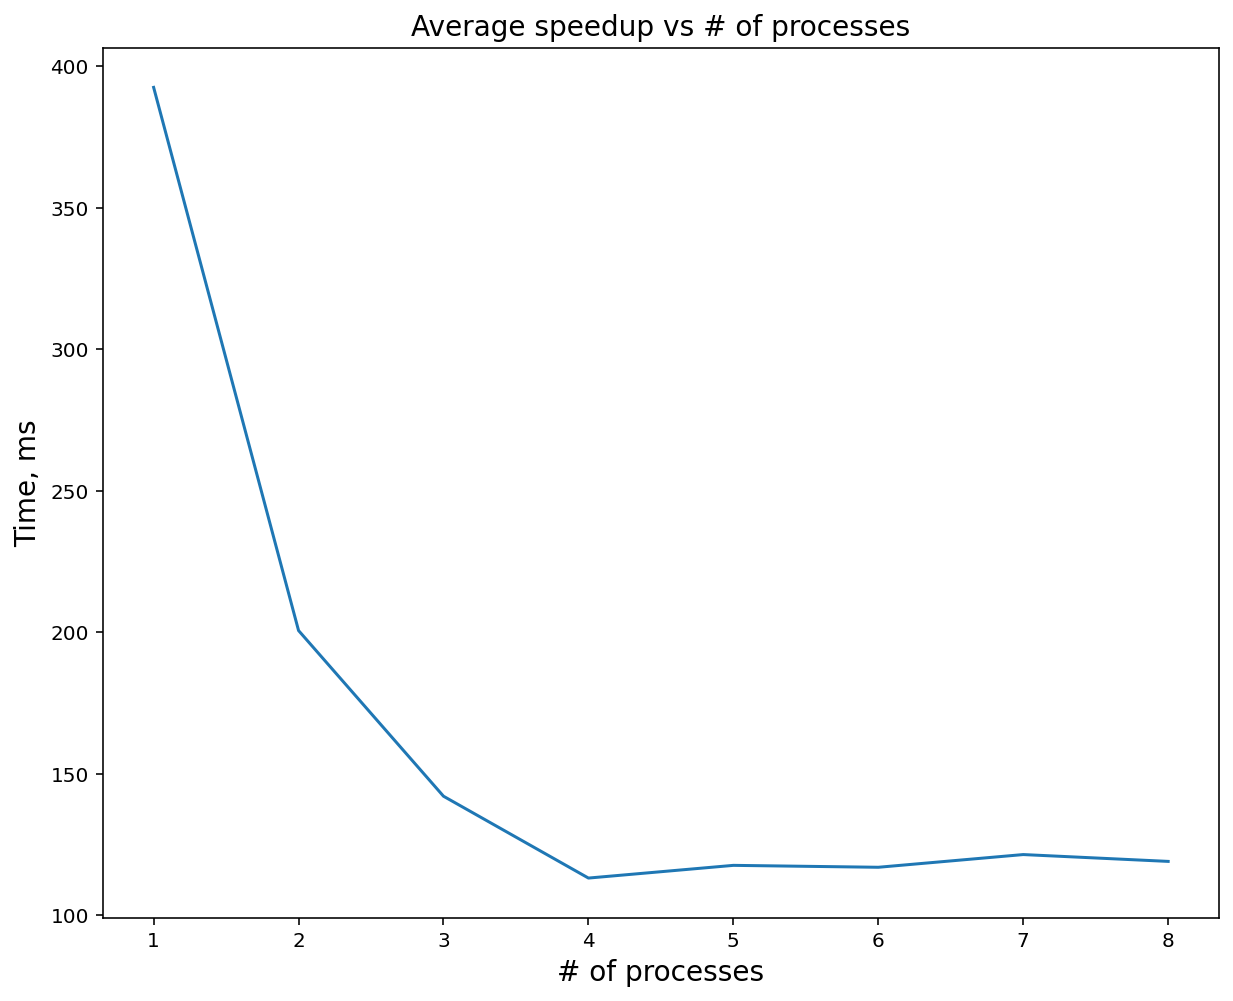

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'
times = time.groupby("n_proc")['time'].mean()
plt.figure(figsize=(10,8))
plt.plot(times)
plt.title('Average speedup vs # of processes', fontsize=14)
plt.ylabel('Time, ms', fontsize=14)
plt.xlabel('# of processes', fontsize=14)
plt.show()

On average, paralellization of our algorithm indeed provides significant speedup, although, too much processess create a too big overhead and dont' improve excecution time.